# part0: imports

In [13]:
%matplotlib inline

import os, sys, pathlib
from importlib import reload
import logging, warnings
logging.basicConfig(level=logging.ERROR)
warnings.simplefilter("ignore")
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as linalg
from sklearn.decomposition import PCA 


import pyaldata as pyal

if "__file__" not in dir():
    try:
        NBPath = pathlib.Path.cwd()
        RepoPath = NBPath.parent
        os.chdir(RepoPath)

        from tools import utilityTools as utility
        from tools import dataTools as dt
        from tools import ccaTools as cca

        import params
        monkey_defs = params.monkey_defs

        set_rc =  params.set_rc_params
        set_rc()
        root = params.root

        os.chdir(RepoPath / 'monkey')
        # %run "_dataset-selection.ipynb"

    finally:
        os.chdir(NBPath)

    print('Done')
    
FIGPATH = params.figPath / 'figS3-example-cca'
FIGPATH.mkdir(exist_ok=True, parents=True)

Done


### Fig S3E-G: Dynamics examples

3D dynamics panel

In [2]:
def plot_pc_example(example_dfs, gs, area='M1', dataset = 'monkey'):
    warnings.simplefilter("ignore")

    if dataset == 'monkey':
        defs = monkey_defs
        animal1 = 'Monkey $C_L$'
        animal2 = 'Monkey $M$'
        colors = utility.get_colors(8)
    elif dataset == 'mouse':
        defs = mouse_defs
        animal1 = example_dfs[0].mouse[0]
        animal2 = example_dfs[1].mouse[0]
        colors = [params.colors.RightTrial, params.colors.LeftTrial]
    else:
        raise ValueError('dataset must be either monkey or mouse')
    
    fig=gs.figure
    
    dfs=[]
    axes=[]
    for i,df in enumerate(example_dfs):
        rates = np.concatenate(df[f'{area}_rates'].values, axis=0)
        rates_model = PCA(n_components=5, svd_solver='full').fit(rates)
        df_ = pyal.apply_dim_reduce_model(df, rates_model, f'{area}_rates', '_pca');
        dfs.append(df_)
        ax = fig.add_subplot(gs[i], projection='3d',fc='None')
        ax.set_title('pca')
        axes.append(ax)
        for tar in range(defs.n_targets):
            df__ = pyal.select_trials(df_, df_.target_id==tar)
            ex = pyal.get_sig_by_trial(df__,'_pca')
            ex = np.mean(ex, axis=2)[:,:3]
            ax.plot(ex[:,0],ex[:,1],ex[:,2],color=colors[tar],lw=1)
            ax.view_init(60,-47)

    AllData = dt.get_data_array(example_dfs, area=area, model=10)
    data1 = np.reshape(AllData[0,...], (-1,10))
    data2 = np.reshape(AllData[1,...], (-1,10))
    A,B,*_ = cca.canoncorr(data1,data2,fullReturn=True)
    coef_ = [A,B]
    for i,sessionData in enumerate(AllData):
        ax = fig.add_subplot(gs[i+3], projection='3d',fc='None')
        U, _, Vh = linalg.svd(coef_[i], full_matrices=False, compute_uv=True, overwrite_a=False)
        ax.set_title('cca')
        axes.append(ax)
        for tar in range(defs.n_targets):
            ex = np.mean(sessionData[tar,...], axis=0)
            ex = ex @ U @ Vh
            ax.plot(ex[:,0],ex[:,1],ex[:,2],color=colors[tar],lw=1)
            ax.view_init(60,-47)

    titles=[f'{animal1}'+r'(\textit{unaligned})',f'{animal2}'+r'(\textit{unaligned})',
            f'{animal1}'+r'(\textit{aligned})',  f'{animal2}'+r'(\textit{aligned})']
    labels = ['PC','PC','CC','CC']
    for i, ax in enumerate(axes):
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_zticks([])
        ax.set_xlabel(f'{labels[i]}1', labelpad=-15)
        ax.set_ylabel(f'{labels[i]}2', labelpad=-15)
        ax.set_zlabel(f'{labels[i]}3', labelpad=-15)
        ax.set_title(titles[i], pad=0, loc='center')
        
    #======== add the arrow
    
    ax = fig.add_subplot(gs[2], fc='None')
    ax = utility.phantom_axes(ax)
    ax.arrow(0,0,1,0,length_includes_head=True, width=.005, head_width=.015,head_length=.1, ec='k', fc='k')
    ax.set_ylim([-.1,.1])
    ax.set_xlim([-.5,1.1])
    ax.text(0.5,0.01,'CCA', ha='center', va='bottom')
    ax.text(0.5,-0.01,'(alignment)', ha='center', va='top')
    
    return axes

#### Plot 

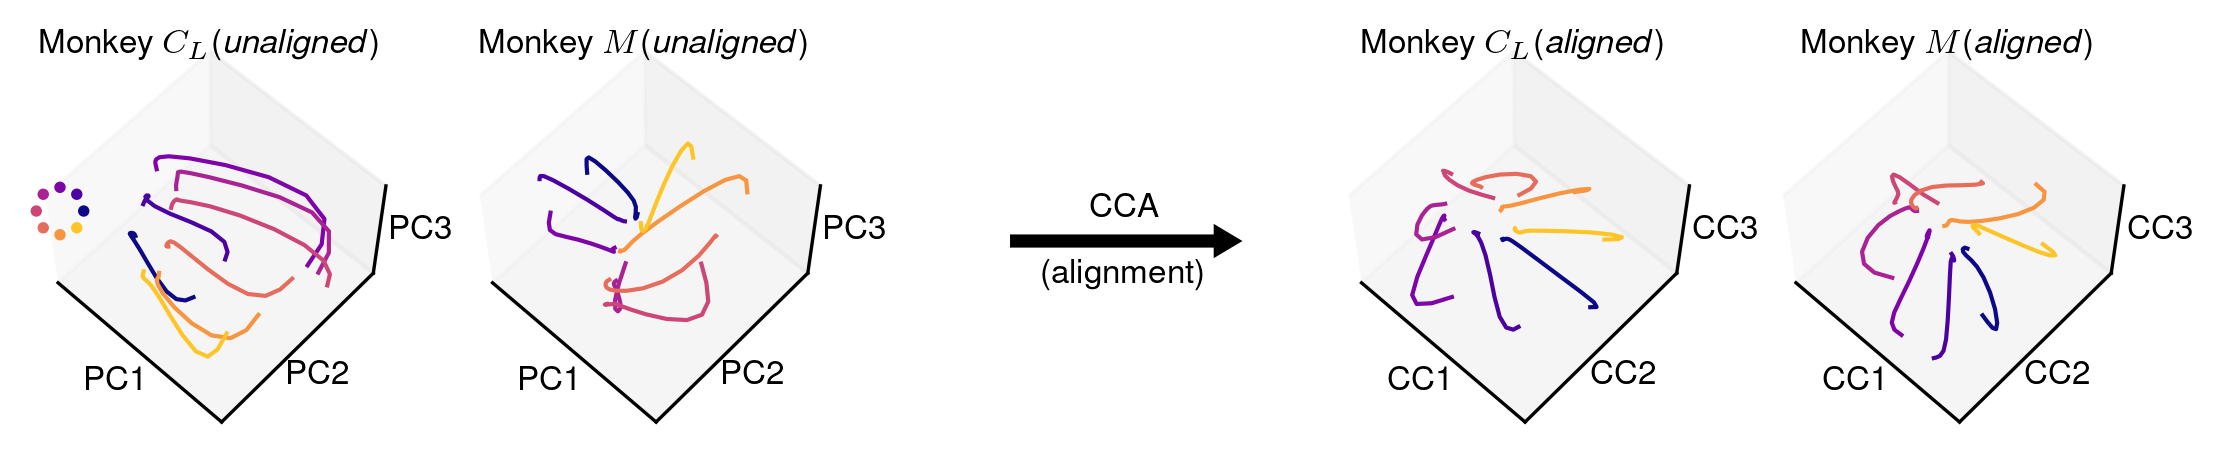

In [15]:
if "__file__" not in dir():
    plt.close('all')
    set_rc()
    figsize=params.LargeFig
    fig=plt.figure(figsize=figsize)

    ##########################################
    # 3: monkey preparation dynamics 
    gs3   =utility.add_gridspec_abs(fig, nrows=1, ncols=5, left=0, 
                                    bottom=figsize[1]-params.panels.proj_3d_align[1]-.3,
                                    width=params.panels.proj_3d_align[0], 
                                    height=params.panels.proj_3d_align[1])
    
    monkey_example_df = dt.get_example_monkey_data(monkey_defs.prep_epoch)
    
    
    axes3 = plot_pc_example(monkey_example_df, gs3, area='M1', dataset = 'monkey')    
    gs3_c = utility.add_gridspec_abs(fig, nrows=1, ncols=1, left=0,
                                    bottom=(axes3[0].get_position().y0+axes3[0].get_position().y1)/2*figsize[1],
                                    width=.2, height=0.2)
    cax3 = fig.add_subplot(gs3_c[0],zorder=10)

    utility.plot_targets(cax3,3)
    cax3.set_xlim(np.array(cax3.get_xlim())*1.15)
    cax3.set_ylim(np.array(cax3.get_ylim())*1.15)
    
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    
    fig.savefig(FIGPATH / 'dynamics-examples.pdf', format='pdf', bbox_inches='tight')
    